# Установка библиотек

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.proportion import proportions_ztest

from scipy.stats import mannwhitneyu

from scipy.stats import t
from scipy.stats import norm

In [3]:
ab_data = pd.read_csv('data/ab_data.csv')

In [6]:
display(ab_data.head())
display(ab_data.info())

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    290482 non-null  int64 
 1   timestamp  290482 non-null  object
 2   group      290482 non-null  object
 3   converted  290482 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 8.9+ MB


None

In [7]:
ab_data['timestamp'] = pd.to_datetime(ab_data['timestamp'], format='%Y-%m-%d')
display(ab_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   user_id    290482 non-null  int64         
 1   timestamp  290482 non-null  datetime64[ns]
 2   group      290482 non-null  object        
 3   converted  290482 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 8.9+ MB


None

In [11]:
dayily_group = ab_data.groupby(['timestamp', 'group']).agg({
    'user_id': 'count',
    'converted': 'sum'
}).reset_index().rename(columns={'user_id': 'users_count'})
display(dayily_group.head())

,timestamp,group,users_count,converted
0,2017-01-02,A,2851,357
1,2017-01-02,B,2848,339
2,2017-01-03,A,6584,749
3,2017-01-03,B,6620,754
4,2017-01-04,A,6573,797


In [19]:
def calc_coversion(converted, sum):
    return (converted/sum)*100
    
#dayily_group['conversion'] = dayily_group.apply(lambda x: calc_coversion(x['converted'], x['users_count']), axis=1)
dayily_group['conversion'] = dayily_group.apply(lambda x: (x['converted']/x['users_count'])*100, axis=1)
display(dayily_group.head())
display(dayily_group[dayily_group['timestamp'] == '2017-01-05'])

,timestamp,group,users_count,converted,conversion
0,2017-01-02,A,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063
3,2017-01-03,B,6620,754,11.389728
4,2017-01-04,A,6573,797,12.125361


,timestamp,group,users_count,converted,conversion
6,2017-01-05,A,6419,791,12.322792
7,2017-01-05,B,6509,743,11.414964


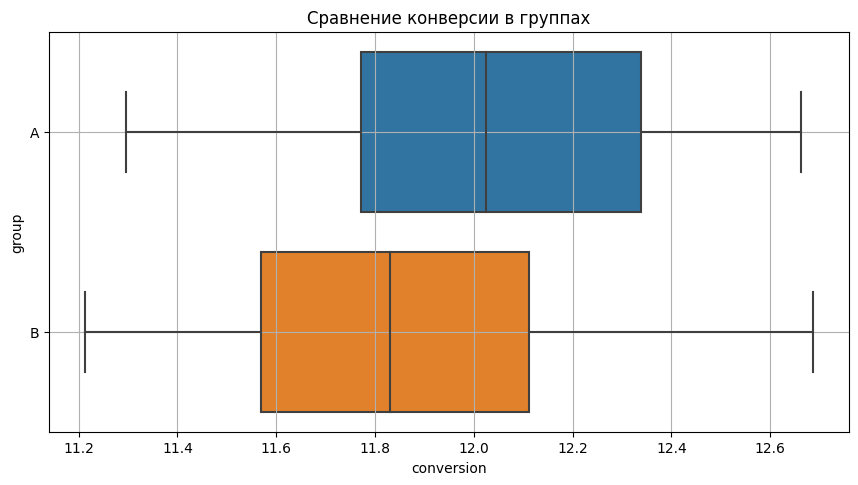

In [21]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4)) 
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1]) 
# строим boxplot для conversion по признаку group
sns.boxplot(data=dayily_group, x='conversion', y='group', ax=ax) 
# задаём подпись к графику
ax.set_title('Сравнение конверсии в группах')
# задаём отображение сетки
ax.grid();

In [27]:
conversion_piv = dayily_group.groupby('group')['conversion'].agg(['mean', 'median'])
display(conversion_piv)

,mean,median
group,,
A,12.032876,12.024261
B,11.872697,11.829582


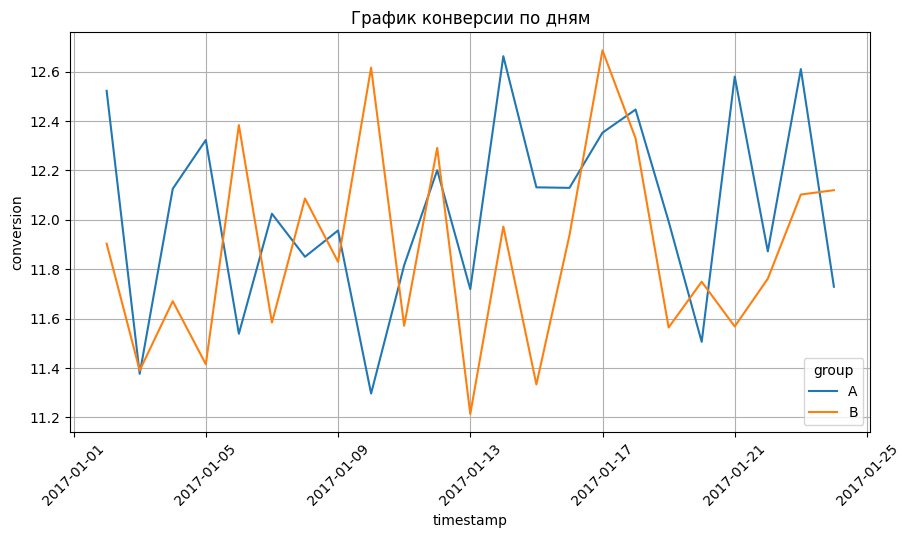

In [28]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для конверсии во времени в каждой группе
sns.lineplot(
    data=dayily_group,
    x='timestamp',
    y='conversion',
    hue='group', 
    ax=ax
)
# задаём подпись к графику
ax.set_title('График конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation=45)
# задаём отображение сетки
ax.grid();

Что можно сказать по такому графику? Да практически ничего! Конверсия у обеих групп «скачет» день ото дня. Понять, какая из групп лучше, — практически невыполнимая задача. 

Для расчёта кумулятивного показателя суммы в Pandas есть специальный метод cumsum(). Давайте посмотрим, как он работает — сначала на данных о ежедневном количестве посетителей для группы А. 

In [33]:
# выделяем данные группы А
daily_data_a = dayily_group[dayily_group['group'] == 'A']
#daily_data_a['cum_users_count'] = 0
# считаем кумулятивное количество посетителей
daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum()
# выводим время, количество посетителей и кумулятивное количество посетителей
display(daily_data_a[['timestamp', 'users_count', 'cum_users_count']].head())

C:\Users\kot\AppData\Local\Temp\ipykernel_8896\908393510.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum()


,timestamp,users_count,cum_users_count
0,2017-01-02,2851,2851
2,2017-01-03,6584,9435
4,2017-01-04,6573,16008
6,2017-01-05,6419,22427
8,2017-01-06,6604,29031


In [37]:
dayily_group['cum_users_count'] = dayily_group.groupby('group')['users_count'].cumsum()
dayily_group['cum_converted'] = dayily_group.groupby('group')['converted'].cumsum()
dayily_group['cum_conversion'] = dayily_group['cum_converted']/dayily_group['cum_users_count'] * 100

display(dayily_group.head())

,timestamp,group,users_count,converted,conversion,cum_users_count,cum_converted,cum_conversion
0,2017-01-02,A,2851,357,12.521922,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063,9435,1106,11.722311
3,2017-01-03,B,6620,754,11.389728,9468,1093,11.544149
4,2017-01-04,A,6573,797,12.125361,16008,1903,11.887806


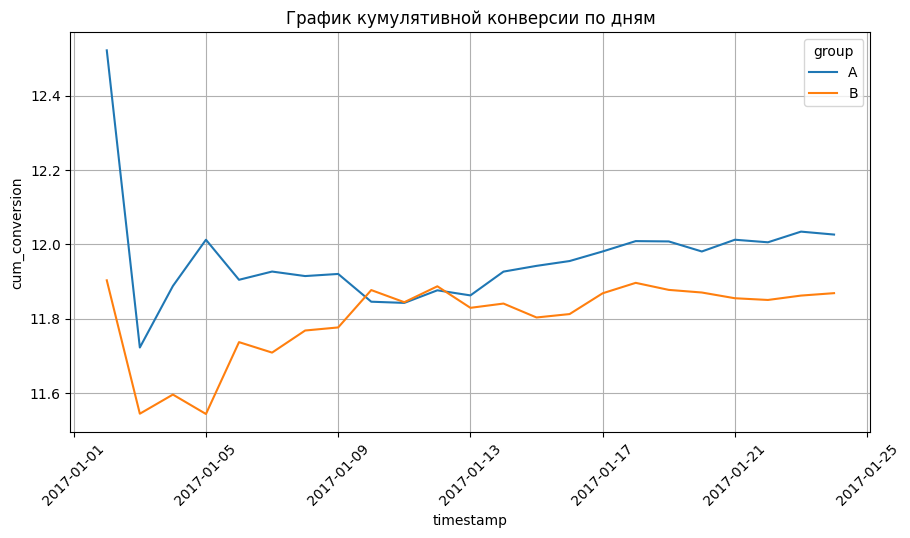

In [38]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='timestamp', y='cum_conversion', data=dayily_group, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

In [39]:
sample_a = pd.read_csv('data/ab_test-redesign_sample_a.csv')
sample_b = pd.read_csv('data/ab_test-redesign_sample_b.csv')

In [42]:
sample_a['date'] = pd.to_datetime(sample_a['date'], format='%Y-%m-%d')
sample_b['date'] = pd.to_datetime(sample_b['date'], format='%Y-%m-%d')
display(sample_a.info(), sample_b.info())

display(sample_a.head(), sample_b.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61571 entries, 0 to 61570
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          61571 non-null  datetime64[ns]
 1   cid           61571 non-null  float64       
 2   transactions  61571 non-null  int64         
 3   revenue       61571 non-null  int64         
 4   group         61571 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 2.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61383 entries, 0 to 61382
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          61383 non-null  datetime64[ns]
 1   cid           61383 non-null  float64       
 2   transactions  61383 non-null  int64         
 3   revenue       61383 non-null  int64         
 4   group         61383 non-null  object        
dty

None

None

,date,cid,transactions,revenue,group
0,2020-11-06,1.001648e+09,0,0,A
1,2020-11-06,1.001936e+09,0,0,A
2,2020-11-06,1.003214e+08,0,0,A
3,2020-11-06,1.004393e+09,0,0,A
4,2020-11-06,1.006382e+09,0,0,A


,date,cid,transactions,revenue,group
0,2020-11-06,1.000135e+09,0,0,B
1,2020-11-06,1.001648e+09,0,0,B
2,2020-11-06,1.003214e+08,0,0,B
3,2020-11-06,1.003652e+09,0,0,B
4,2020-11-06,1.003833e+09,0,0,B


In [46]:
daily_sample_a = sample_a.groupby(['date']).agg({
    'cid': 'count',
    'transactions': 'sum',
    'revenue': 'sum'
    
}).reset_index().rename(columns={'cid': 'users'})
display(daily_sample_a.head())
display(daily_sample_a[daily_sample_a['date'] == '2020-11-08'])

daily_sample_b = sample_b.groupby(['date']).agg({
    'cid': 'count',
    'transactions': 'sum',
    'revenue': 'sum'
    
}).reset_index().rename(columns={'cid': 'users'})
display(daily_sample_b.head())
display(daily_sample_b[daily_sample_b['date'] == '2020-11-08'])

,date,users,transactions,revenue
0,2020-11-06,2576,16,1577279
1,2020-11-07,2704,23,1721886
2,2020-11-08,3354,25,846051
3,2020-11-09,3234,18,708830
4,2020-11-10,3022,29,826984


,date,users,transactions,revenue
2,2020-11-08,3354,25,846051


,date,users,transactions,revenue
0,2020-11-06,2499,19,996645
1,2020-11-07,2804,19,555499
2,2020-11-08,3291,24,3044842
3,2020-11-09,3062,25,1285836
4,2020-11-10,3072,30,2414726


,date,users,transactions,revenue
2,2020-11-08,3291,24,3044842


In [57]:
daily_sample_a['cum_users_count'] = daily_sample_a['users'].cumsum()
daily_sample_a['cum_transactions'] = daily_sample_a['transactions'].cumsum()
daily_sample_a['cum_revenue'] = daily_sample_a['revenue'].cumsum()
daily_sample_a['cum_conversion'] = daily_sample_a['cum_transactions']/daily_sample_a['cum_users_count'] *100
daily_sample_a['average_bill'] = daily_sample_a['cum_revenue']/daily_sample_a['cum_transactions'] *100

daily_sample_b['cum_users_count'] = daily_sample_b['users'].cumsum()
daily_sample_b['cum_transactions'] = daily_sample_b['transactions'].cumsum()
daily_sample_b['cum_revenue'] = daily_sample_b['revenue'].cumsum()
daily_sample_b['cum_conversion'] = daily_sample_b['cum_transactions']/daily_sample_b['cum_users_count'] *100
daily_sample_b['average_bill'] = daily_sample_b['cum_revenue']/daily_sample_b['cum_transactions'] *100

display(daily_sample_a.head(), daily_sample_b.head())
print(daily_sample_a.agg({'cum_conversion':'median'}))
print(daily_sample_b.agg({'cum_conversion':'median'}))

,date,users,transactions,revenue,cum_users_count,cum_transactions,cum_revenue,cum_conversion,average_bill
0,2020-11-06,2576,16,1577279,2576,16,1577279,0.621118,9.857994e+06
1,2020-11-07,2704,23,1721886,5280,39,3299165,0.738636,8.459397e+06
2,2020-11-08,3354,25,846051,8634,64,4145216,0.741256,6.476900e+06
3,2020-11-09,3234,18,708830,11868,82,4854046,0.690934,5.919568e+06
4,2020-11-10,3022,29,826984,14890,111,5681030,0.745467,5.118045e+06


,date,users,transactions,revenue,cum_users_count,cum_revenue,cum_transactions,cum_conversion,average_bill
0,2020-11-06,2499,19,996645,2499,996645,19,0.760304,5.245500e+06
1,2020-11-07,2804,19,555499,5303,1552144,38,0.716576,4.084589e+06
2,2020-11-08,3291,24,3044842,8594,4596986,62,0.721434,7.414494e+06
3,2020-11-09,3062,25,1285836,11656,5882822,87,0.746397,6.761864e+06
4,2020-11-10,3072,30,2414726,14728,8297548,117,0.794405,7.091921e+06


cum_conversion    0.715186
dtype: float64
cum_conversion    0.757292
dtype: float64


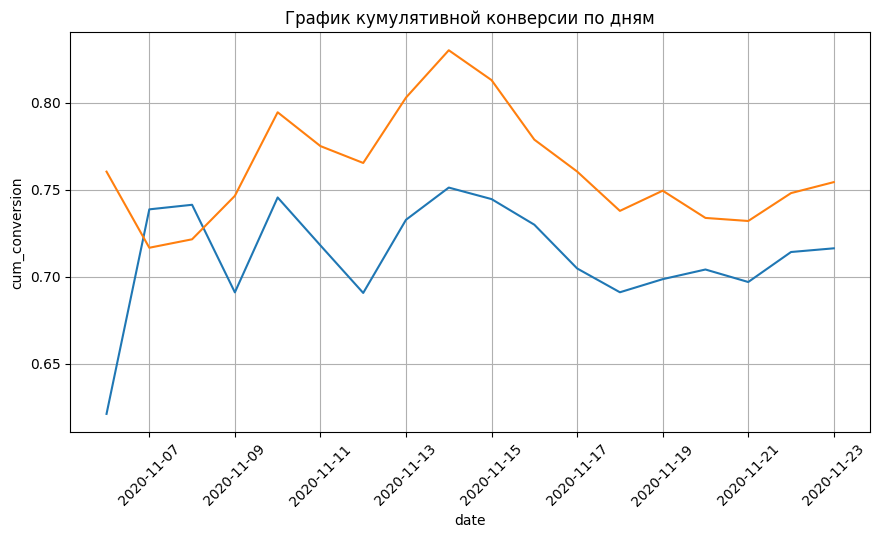

In [69]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=daily_sample_a, ax=ax)
sns.lineplot(x='date', y='cum_conversion', data=daily_sample_b, ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

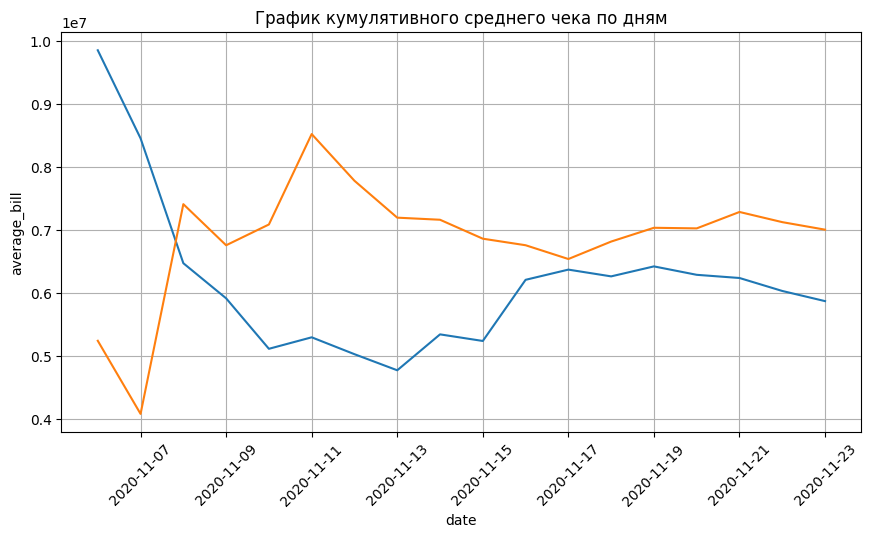

In [71]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивного среднего чека во времени в каждой группе
sns.lineplot(x='date', y='average_bill', data=daily_sample_a, ax=ax)
sns.lineplot(x='date', y='average_bill', data=daily_sample_b, ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивного среднего чека по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

Нулевая гипотеза нашего теста всегда будет звучать следующим образом:

     то есть истинные пропорции в группах равны.

А вот альтернативных может быть несколько:

    (двусторонняя): 

, то есть истинные пропорции в группах не равны.
(левосторонняя):, то есть истинная пропорция группы А меньше, чем в группе B.
(правосторонняя):

    , то есть истинная пропорция группы А больше, чем в группе B.

✏️ Применим z-тест для пропорций на примере конверсии нашего интернет-магазина. 

Импортируем функцию proportions_ztest() из модуля statsmodels:

from statsmodels.stats.proportion import proportions_ztest

Напомним, что для получения z-статистики и p-value нам необходимо передать в функцию следующие аргументы:

    count — количество «успехов» (в каждой из групп). В нашем случае — количество пользователей, которые совершили целевое действие в каждой группе.
    nobs — количество наблюдений (в каждой из групп), то есть размер выборки.
    alternative — альтернативная гипотеза. Может быть: 'two-sided' — двусторонняя, 'smaller' — левосторонняя, 'larger' — правосторонняя. По умолчанию параметр равен 'two-sided'. 

✏️ Итак, сгруппируем данные по признаку группы и рассчитаем количество «успехов» (сумма по столбцу converted) и общее количество наблюдений (количество непустых значений в столбце converted) для каждой группы.

In [72]:
converted_piv= ab_data.groupby('group')['converted'].agg(
    ['sum', 'count']
)
display(converted_piv)

,sum,count
group,,
A,17467,145241
B,17238,145241


Итак, будем проверять следующую новую гипотезу:

    , то есть конверсии в группах А и B равны.

При правосторонней альтернативной гипотезе (ранее из кумулятивных графиков мы видели, что кумулятивная конверсия в группе А выше, чем в группе B, поэтому мы хотим удостовериться в этом с помощью статистического теста, и нам подойдёт правосторонняя гипотеза):

    , то есть конверсия в группе А выше, чем конверсия в группе B.

Зададим уровень значимости и будем сравнивать полученное p-value с ним. По умолчанию функция proportions_ztest() возвращает z-статистику и p-value для двусторонней альтернативной гипотезы (конверсии в группах не равны). 

✏️ Z-статистика нас пока что не интересует, а вот p-value занесём в отдельную переменную для дальнейшего сравнения с уровнем значимости.

In [75]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'

alpha = 0.05 # уровень значимости

# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value:  0.1
# Принимаем нулевую гипотезу. Конверсии в группах А и B равны



p-value:  0.1
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


In [76]:
time_data = pd.read_excel('data/time_data.xlsx')
display(time_data.head())

,time(A),time(B)
0,435.0,549.2
1,454.5,630.2
2,447.0,437.2
3,480.0,637.2
4,561.0,712.4


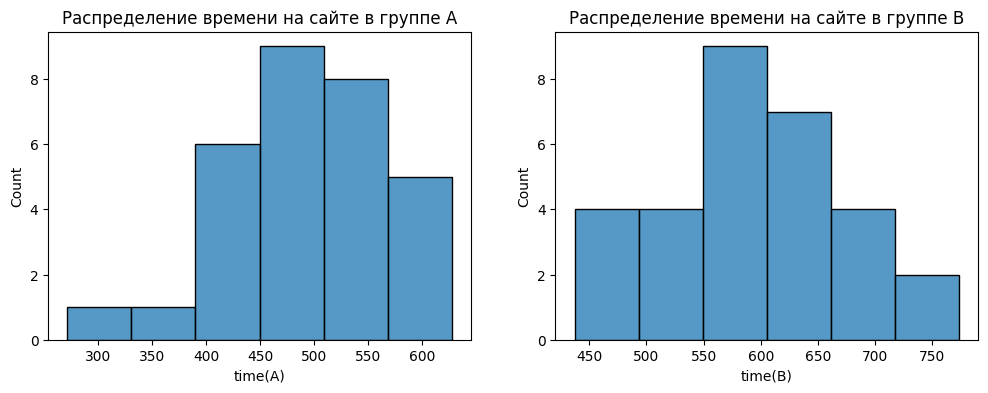

In [77]:
#создаём 2 графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#строим гистограмму для времени на сайте в каждой группе
sns.histplot(x='time(A)', data=time_data, ax=axes[0])
sns.histplot(x='time(B)', data=time_data, ax=axes[1])
#задаём названия графикам
axes[0].set_title('Распределение времени на сайте в группе А');
axes[1].set_title('Распределение времени на сайте в группе B');

In [78]:


from scipy.stats import shapiro
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости

# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(time_data['time(A)'])
shapiro_result_b = shapiro(time_data['time(B)'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value группы А 0.43
# p-value группы B 0.12
# Принимаем нулевую гипотезу. Распределения в обеих группах нормальные



p-value группы А 0.43
p-value группы B 0.12
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


Итак, распределение в обеих группах нормальное, а значит, мы можем воспользоваться T-тестом для того, чтобы сравнить среднее время посещения сайта в группах.

Выдвигаем нулевую гипотезу:

    , то есть среднее время в группах А и B одинаково.

При левосторонней альтернативной гипотезе:

    , то есть среднее время в группе А меньше, чем в группе B.

✏️ Применим T-тест для сравнения средних — функцию ttest_ind() из модуля scipy.stats. Обратите внимание, что левосторонняя альтернативная гипотеза в модуле scipy указывается в параметре alternative как 'less' (правосторонняя — 'greater’):

In [79]:


from scipy.stats import ttest_ind

# нулевая и альтернативная гипотезы
H0 = 'Среднее время в группах одинаково'
H1 = 'Среднее время в группе А меньше, чем в группе B'
alpha = 0.05 #уровень значимости

#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=time_data['time(A)'],
    b=time_data['time(B)'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value: 0.0
# Отвергаем нулевую гипотезу. Среднее время в группах одинаково
# Альтернативная гипотеза. H1: Среднее время в группе А меньше, чем в группе B



p-value: 0.0
Отвергаем нулевую гипотезу. Среднее время в группах одинаково
Альтернативная гипотеза. H1: Среднее время в группе А меньше, чем в группе B


 Задание 5.2
1 point possible (graded)

Проверьте гипотезу о равенстве конверсий в группах А и B при альтернативной гипотезе: Конверсия в группе А меньше, чем конверсия в группе B. Используйте функцию proportions_ztest() из модуля statsmodels.stats.proportion. В качестве уровня значимости возьмите .

In [119]:
print(int(sample_a['transactions'].agg({'transactions':'sum'})), int(sample_b['transactions'].agg({'transactions':'sum'})))
print(int(sample_a['cid'].agg({'cid':'count'})), int(sample_b['cid'].agg({'cid':'count'})))



# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'

alpha = 0.1 # уровень значимости

# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=[int(sample_a['transactions'].agg({'transactions':'sum'})), int(sample_b['transactions'].agg({'transactions':'sum'}))], #число "успехов"
    nobs=[int(sample_a['cid'].agg({'cid':'count'})), int(sample_b['cid'].agg({'cid':'count'}))], #общее число наблюдений
    alternative='smaller'
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value:  0.1
# Принимаем нулевую гипотезу. Конверсии в группах А и B равны

441 463
61571 61383
p-value:  0.22
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


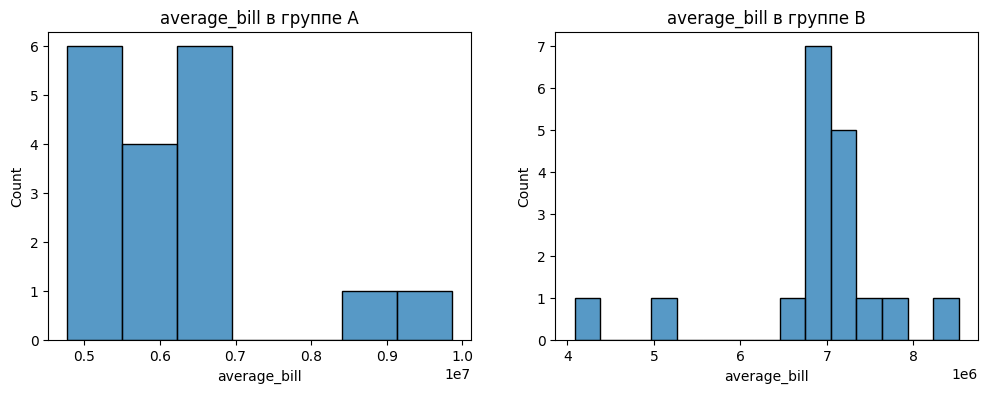

In [152]:
#создаём 2 графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#строим гистограмму для average_bill в каждой группе
sns.histplot(x='average_bill', data=daily_sample_a, ax=axes[0])
sns.histplot(x='average_bill', data=daily_sample_b, ax=axes[1])
#задаём названия графикам
axes[0].set_title('average_bill в группе А');
axes[1].set_title('average_bill в группе B');

In [144]:
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'
alpha = 0.1

In [121]:
_, p = shapiro(daily_sample_a['average_bill'])
print('p=%.3f' % p)

# Интерпретация 

if p > alpha:
	print(H0)
else:
	print(Ha)

p=0.001
Данные не распределены нормально (мы отвергаем H0)


In [145]:
_, p = shapiro(daily_sample_b['average_bill'])
print('p=%.3f' % p)
print(_,p)

# Интерпретация 

if p > alpha:
	print(H0)
else:
	print(Ha)

p=0.002
0.8013818860054016 0.0015888081397861242
Данные не распределены нормально (мы отвергаем H0)


In [125]:
H0 = 'равенство ежедневных средних чеков'
Ha = 'ежедневный средний чек в А меньше, чем в группе B'
alpha = 0.1

In [142]:
from scipy.stats import mannwhitneyu

_, p = mannwhitneyu(daily_sample_a['average_bill'], daily_sample_b['average_bill'], alternative='less')
print('p=%.3f' % p)

print(_,p)
# Интерпретация 

if p > alpha:
	print(H0)
else:
	print(Ha)

p=0.001
63.0 0.0009153623248471153
ежедневный средний чек в А меньше, чем в группе B


Была опрошена случайная выборка из 36 жителей региона об их затратах на продукты питания за последний месяц. Выборочное среднее оказалось равным 16 100 рублей.
Допустим, откуда-то известно, что истинное стандартное отклонение расходов равно 12 000 рублей.
Нам нужно построить доверительный интервал для истинных средних расходов жителя данного региона на продукты питания в месяц. Интервал должен определять истинное значение с надежностью в 95 %.


По условию задачи у нас есть выборка размером 36 человек. Далее, просуммировав затраты жителей региона и поделив на их количество, было получено выборочное среднее 16100

рублей. Ещё нам дано значение истинного (НЕ выборочного) стандартного отклонения 12000 рублей. То есть в среднем разброс затрат составляет 12 000 рублей. Ещё нам сказали, что рассчитанный нами интервал должен быть надёжным с уровнем надёжности 0.95.  


Найти значение z-критического для любого уровня значимости можно при помощи функции norm.ppf() из модуля scipy.stats. По специфическим причинам реализации функция возвращает не совсем z-критическое, а его отрицательный модуль, поэтому мы берём его со знаком минус.

Функция norm.ppf(x) возвращает значение z-крит, левее (ниже) которого лежит доля левого хвоста стандартного нормального распределения. Выражение norm.ppf(α/2) вернёт
, то есть значение крит, ниже которого всех значений стандартного нормального распределения. Это число отрицательное, мы берём его со знаком минус, чтобы получить .

In [137]:


from scipy.stats import norm


def confidence_interval(z_crit, x_mean, sigma, n):
    eps = z_crit * sigma/(n ** 0.5) #погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    interval = (round(lower_bound, 2), round(upper_bound, 2)) # создаём кортеж из округлённых границ интервала
    return interval

n = 36 # размер выборки
x_mean = 16100 # выборочное среднее
sigma = 12000 # истинное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

z_crit = -norm.ppf(alpha/2) # z критическое

print('Доверительный интервал: {}'.format(confidence_interval(z_crit, x_mean, sigma, n))) # выводим результат


Доверительный интервал: (12180.07, 20019.93)


Аккумуляторный завод производит батарейки, срок службы которых имеет истинное стандартное отклонение в 2.4 месяца. Средний срок службы батареек в случайной выборке из 64 штук составил 12.35 месяца. Необходимо построить 90 %-ный доверительный интервал для истинного среднего срока службы производимой батарейки и ответить на вопросы заданий ниже.


In [136]:
n = 64 # размер выборки
x_mean = 12.35 # выборочное среднее
sigma = 2.4 # истинное стандартное отклонение
gamma = 0.90 # уровень надёжности
alpha = 1 - gamma # уровень значимости

z_crit = -norm.ppf(alpha/2) # z критическое
print(z_crit)

print('Доверительный интервал: {}'.format(confidence_interval(z_crit, x_mean, sigma, n))) # выводим результат

1.6448536269514729
Доверительный интервал: (11.86, 12.84)


Управляющий супермаркета хочет оценить, сколько денег покупатели тратят за один поход в супермаркет в среднем. На основании ранее собранных данных известно, что расходы одного покупателя распределены приблизительно нормально. Управляющий взял случайную выборку из 15 покупателей и выяснил, что их средние расходы равны 2 000 рублей, а выборочное стандартное отклонение равно 400 рублей.

Для оценки управляющий хочет построить доверительный интервал с надёжностью в 95 %.


Найти значение t-критического для любого уровня значимости можно, используя функцию t.ppf() из модуля scipy.stats. Для этого в функцию передаётся интересующий уровень значимости () и число степеней свободы (). Аналогично z-критическому функция возвращает отрицательный модуль t-критического, поэтому мы берём его со знаком минус:

In [140]:
from scipy.stats import t

def confidence_interval_random(t_crit, x_std, sigma, n):
    eps = t_crit * x_std/(n ** 0.5) # погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
    return interval


n = 15 # размер выборки
k = n - 1 # число степеней свободы
x_mean = 2000 # выборочное среднее
x_std = 400 # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

t_crit = -t.ppf(alpha/2, k) # t-критическое

print('Доверительный интервал: {}'.format(confidence_interval_random(t_crit, x_std, sigma, n))) # выводим результат


Доверительный интервал: (1778, 2222)


Чиновника интересует сумма подоходного налога, выплачиваемого домохозяйствами за год. На случайной выборке из 25 домохозяйств был посчитан средний размер выплаченного налога, и он составил $ 3 540. Также известно выборочное отклонение величины подоходного налога, равное $ 1 150. 

In [141]:
n = 25 # размер выборки
k = n - 1 # число степеней свободы
x_mean = 3540 # выборочное среднее
x_std = 1150 # выборочное стандартное отклонение
gamma = 0.90 # уровень надёжности
alpha = 1 - gamma # уровень значимости

t_crit = -t.ppf(alpha/2, k) # t-критическое

print('Доверительный интервал: {}'.format(confidence_interval_random(t_crit, x_std, sigma, n))) # выводим результат


Доверительный интервал: (3146, 3934)


In [164]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'

alpha = 0.05 # уровень значимости

# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=[14,100000], #число "успехов"
    nobs=[20,200000], #общее число наблюдений
    alternative='larger'
)
# выводим результат на экран
print(f'{p_value=}')
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value:  0.1
# Принимаем нулевую гипотезу. Конверсии в группах А и B равны

p_value=0.03682633914983001
p-value:  0.04
Отвергаем нулевую гипотезу. Конверсии в группах А и B равны
Альтернативная гипотеза. H1: Конверсия в группе А выше, чем конверсия в группе B


In [165]:
ab_data = pd.read_csv('data/ab_data.csv')
ab_data.head()

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


In [166]:
#фильтруем данные группы А
a_data = ab_data[ab_data['group'] == 'A']
#фильтруем данные группы B
b_data = ab_data[ab_data['group'] == 'B']

Давайте на этот раз оформим расчёт в виде функции: объявим функцию proportions_conf_interval(). У данной функции будет три аргумента: n — размер выборки, x_p — выборочная пропорция и gamma — уровень надёжности (по умолчанию он равен 0.95). Функция будет возвращать кортеж из вычисленных границ доверительного интервала, умноженных на 100 % и округлённых до второго знака после запятой.

In [187]:
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

In [191]:
print(a_data['converted'].sum()/a_data['user_id'].count(), a_data['converted'].mean())

0.12026218492023602 0.12026218492023602


In [180]:
conf_interval_a = proportions_conf_interval(
n=a_data['user_id'].count(), # размер выборки
x_p=a_data['converted'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['user_id'].count(), # размер выборки
x_p=b_data['converted'].mean() # выборочная пропорция
)
print(a_data['converted'].mean())
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))
# Доверительный интервал для конверсии группы А: (11.86, 12.19)
# Доверительный интервал для конверсии группы B: (11.7, 12.03)

0.12026218492023602
Доверительный интервал для конверсии группы А: (11.86, 12.19)
Доверительный интервал для конверсии группы B: (11.7, 12.03)


 Создадим функцию diff_proportions_conf_interval() со следующими аргументами: n — список из размеров выборки для групп А и B соответственно, xp — список из выборочных пропорций для групп А и B соответственно и gamma — уровень надёжности (по умолчанию он равен 0.95). Функция будет возвращать кортеж из вычисленных границ доверительного интервала разницы конверсий, умноженных на 100 % и округлённых до второго знака после запятой.

In [169]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 -gamma
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)
     

In [172]:
# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['converted'].mean(), b_data['converted'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.39, 0.08)


Задание 6.9 

Чтобы оценить удовлетворённость клиентов сети отелей, менеджер взял случайную выборку из 189 комментариев, оставленных посетителями на онлайн-платформе по бронированию, и провёл анализ их содержания. Выяснилось, что 132 комментария были положительными, остальные — негативными.

Чему равна выборочная пропорция положительных комментариев? Укажите с точностью до трёх знаков после разделительной точки.

Найдите 90 % доверительный интервал для истинной пропорции положительных комментариев. Ответ приведите в процентах и округлите до двух знаков после запятой. При расчёте используйте z-критическое.

In [199]:
n = 189 # размер выборки
n_positive = 132 # число положительных исходов
x_p = n_positive/n # выборочная пропорция
print('Выборочная пропорция: {}'.format(round(x_p, 3)))
 
print('Доверительный интервал: {}'.format(proportions_conf_interval(n, x_p, gamma=0.9)))

Выборочная пропорция: 0.698
Доверительный интервал: (64.35, 75.33)


: 

Задание 6.10

Постройте 95 %-ый доверительный интервал разности полученных конверсий. Ответ приведите в процентах и округлите границы интервала до второго знака после запятой. При расчёте используйте z-критическое.

In [196]:
n = 1000 # размер выборки обеих групп
n_positive_a = 45 # число конвертировавших в группе А
n_positive_b = 50 # число конвертировавших в группе B
xp_a = n_positive_a/n # выборочная пропорция группы A
xp_b = n_positive_b/n # выборочня пропорция группы B
confidence_interval = diff_proportions_conf_interval(
    n=[n, n],
    xp=[xp_a, xp_b]
)
print('Доверительный интервал: {}'.format(confidence_interval))

Доверительный интервал: (-1.36, 2.36)
